In [3]:
import sys
sys.path.append('../')
import numpy as np
import copy
from PIL import Image
import open3d as o3d
import matplotlib.pyplot as plt
from magpie.perception import pcd
# from open3d.web_visualizer import draw

In [2]:
from magpie import realsense_wrapper as real
rsc = real.RealSense()
rsc.initConnection()

In [8]:
rsc.disconnect()

In [7]:
# from magpie.perception.label_owlvit import LabelOWLViT
from magpie.perception.label_owlv2 import LabelOWLv2
# path = "google/owlvit-base-patch32"
# label_vit = LabelOWLViT(pth=path, topk=3)
# label_vit = LabelOWLViT(pth=path, topk=3, v2=True)
label_vit = LabelOWLv2(topk=3)

2024-09-11 11:47:37.166763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 11:47:37.166816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 11:47:37.168142: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-11 11:47:37.176291: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 11:47:38.167672: W tensorflow/compiler/tf2

In [4]:
# from magpie.perception.mask_sam import MaskSAM
# ckpt = "/home/will/workspace/owlvit_segment_anything/sam_vit_h_4b8939.pth"
# mask_sam = MaskSAM(ckpt)

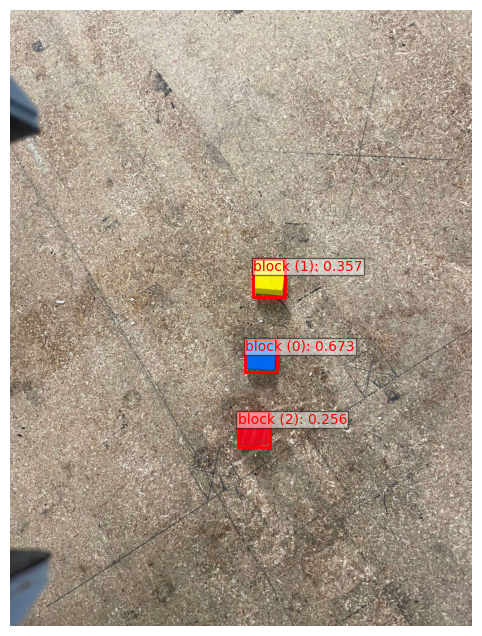

In [8]:
p, rgbd_image = rsc.getPCD()
# p, rgbd_image = rsc.getPCD(adjust_extrinsics=True)
image = np.array(rgbd_image.color)
# image = Image.open('test.jpg')
queries = ["a photo of an apple", "a photo of a lemon", "a photo of a lime", "a photo of a pear", "a photo of a onion"]
queries = ["a photo of an blue cylindrical container", "a photo of a small red cubic block", "a photo of a screwdriver handle" ]
queries = ["a photo of a black student ID card", "a photo of a small orange fruit", "a photo of a small plastic bag"]
queries = ["a photo of an avocado", "a photo of a small orange fruit", "a photo of a small plastic bag", "a photo of a paper airplane"]
queries = ["a photo of a water bottle with a red top"]
queries = ["a photo of a blue block"]
# queries = ["a photo of a tail"]
# queries = ["a photo of a black handle of a pair of scissors"]
abbrevq = ["apple", "lemon", "lime", "pear", "onion"]
abbrevq = ["blue", "block", "handle"]
abbrevq = ["card", "orange", "bag"]
abbrevq = ["avocado", "orange", "bag", "paper airplane"]
abbrevq = ["block"]
label_vit.set_threshold(0.001)
bboxes, uboxes = label_vit.label(image, queries, abbrevq, plot=True, topk=True)


In [69]:
index = 0
# this does the [x, y, z] --> [y, -x, z] grasp pose switch, and the -y inversio on the y-axis orientation
# rgbd_image, cpcd, tmat = pcd|.get_segment(label_vit.boxes, index, rgbd_image, rsc, type="box", display=False)
rgbd_image, cpcd, tmat, pca = pcd.get_segment(label_vit.sorted_labeled_boxes_coords, 
                                         index, 
                                         rgbd_image, 
                                         rsc, 
                                        #  type="box-dbscan", 
                                         type="box", 
                                        #  method="quat", 
                                         method="iterative", 
                                        #  display=False,
                                         display=True,
                                         viz_scale=1000)
tmat, tmat[:3, 3]

modified indices: [2 0 1]
z-axis dot product: [0.7069246]
[Open3D INFO] Window window_25 created.


WebVisualizer(window_uid='window_25')

(array([[ 4.04647815e-01,  8.32794272e-01, -3.77774862e-01,
         -1.88390845e-04],
        [-5.80105862e-01,  5.53112486e-01,  5.97949635e-01,
         -2.42551539e-02],
        [ 7.06921024e-01, -2.28096015e-02,  7.06924598e-01,
          3.87766416e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]]),
 array([-1.88390845e-04, -2.42551539e-02,  3.87766416e-01]))

[Open3D INFO] Sending init frames to window_25.


[6213:986][6958] (stun_port.cc:96): Binding request timed out from 192.168.0.x:58796 (enp3s0)
[6228:646][6958] (stun_port.cc:96): Binding request timed out from 192.168.0.x:43809 (enp3s0)
[6586:517][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[6586:582][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[6586:625][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[6586:630][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[6586:736][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[6586:781][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState() called in state DTLS_TRANSPORT_CLOSED.
[6586:818][6958] (dtls_transport.cc:529): DtlsTransport[0|1|R_]: OnWritableState

In [25]:
mc = cpcd.compute_mean_and_covariance()
# rotate grasp pose -pi/2 about z-axis
grasp_pose = [mc[0][1], -mc[0][0], mc[0][2]]
grasp_pose

[-0.0011390042385238236, -0.0048835902492652275, 0.22529418163468426]

[834:161][6958] (stun_port.cc:96): Binding request timed out from 192.168.0.x:50492 (enp3s0)


In [11]:
tmat

array([[-5.17773847e-02, -2.90515451e-01, -9.55468406e-01,
        -1.54231234e-02],
       [ 6.57397265e-01, -7.30132070e-01,  1.86375954e-01,
        -4.15442091e-04],
       [-7.51763219e-01, -6.18472258e-01,  2.28788392e-01,
         2.96205793e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [100]:
mobb = cpcd.get_minimal_oriented_bounding_box()
obb = cpcd.get_oriented_bounding_box()
mobb.extent, obb.extent
width = np.min([*mobb.extent[:3], *obb.extent[:3]])
width

0.0437999963760376

In [16]:
o3d.visualization.draw_geometries([cpcd, cpcd1, cpcd2])

In [15]:
# Segmentation Masks
mask_sam.set_image_and_labels(np.array(rgbd_image.color), np.array([np.array(i[0]) for i in label_vit.boxes]), label_vit.labels)

In [17]:
masks = mask_sam.get_masks(label_vit.labels)

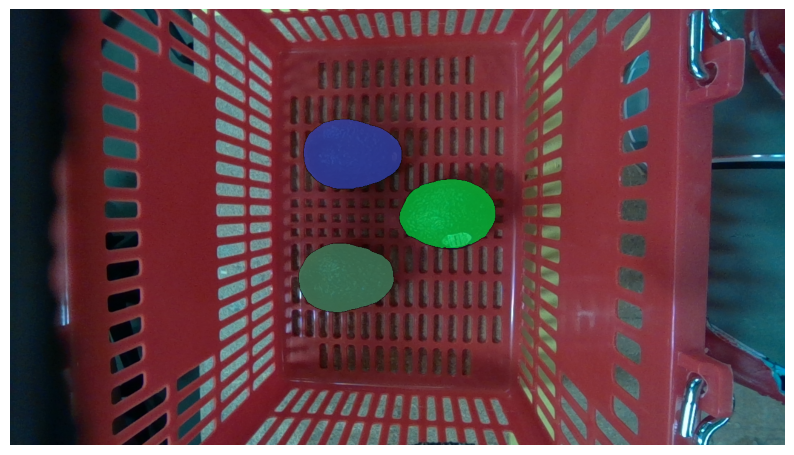

In [38]:
mask_sam.show_all_masks(np.array(rgbd_image.color))

In [43]:
# get first entry of tuple in boxes
b = [i[0] for i in label_vit.boxes]
l = label_vit.labels

(-0.5, 1279.5, 719.5, -0.5)

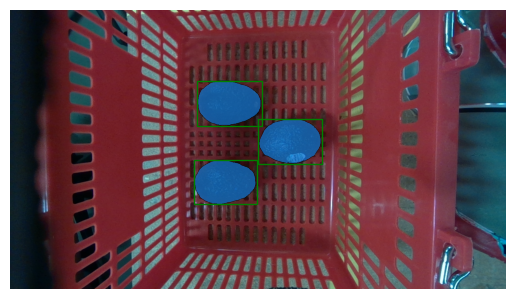

In [50]:
from PIL import Image, ImageDraw, ImageFont

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=1))  


plt.imshow(rgbd_image.color)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=False)
for box in b:
    show_box(np.array(box), plt.gca())
plt.axis('off')



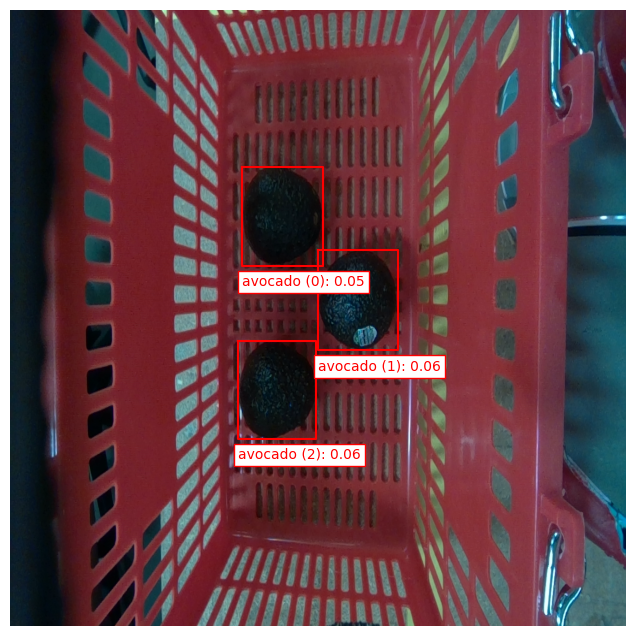

In [39]:
_, _ = label_vit.label(np.array(rgbd_image.color), queries, abbrevq, plot=True)

In [63]:
index = 0
rgbd_image, mcpcd, tmat, pca = pcd.get_segment(mask_sam.masks, 
                                          index, 
                                          rgbd_image, 
                                          rsc, 
                                          type="mask", 
                                          viz_scale=2500.0, 
                                          display=False,
                                          method="iterative")

z-axis dot product: [0.98546151]


In [64]:
tmat

array([[ 0.98697494, -0.16045605, -0.01159015, -0.05734346],
       [-0.16008375, -0.97244122, -0.16950301,  0.03629804],
       [-0.01592704, -0.16915062,  0.98546151,  0.31724131],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [65]:
index = 1
rgbd_image, mcpcd1, tmat, pca1 = pcd.get_segment(mask_sam.masks, 
                                          index, 
                                          rgbd_image, 
                                          rsc, 
                                          type="mask", 
                                          viz_scale=2500.0, 
                                          display=False,
                                          method="iterative")

z-axis dot product: [0.99064697]


In [66]:
tmat

array([[ 0.97236925,  0.23241679, -0.02191985, -0.00644827],
       [ 0.22748174, -0.96442416, -0.13467775, -0.04274227],
       [ 0.05244141, -0.12597013,  0.99064697,  0.30846284],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [67]:
index = 2
rgbd_image, mcpcd2, tmat, pca2 = pcd.get_segment(mask_sam.masks, 
                                          index, 
                                          rgbd_image, 
                                          rsc, 
                                          type="mask", 
                                          viz_scale=2500.0, 
                                          display=False,
                                          method="iterative")

z-axis dot product: [0.98567079]


In [68]:
tmat

array([[ 0.98665647, -0.16180182, -0.01814324,  0.04438557],
       [-0.1565328 , -0.97333117,  0.16770185,  0.04194964],
       [ 0.04479385,  0.1626241 ,  0.98567079,  0.32025074],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [35]:
tmat, tmat[:3, 3]

(array([[ 0.98665647, -0.16180182, -0.01814324,  0.04438557],
        [-0.1565328 , -0.97333117,  0.16770185,  0.04194964],
        [ 0.04479385,  0.1626241 ,  0.98567079,  0.32025074],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([0.04438557, 0.04194964, 0.32025074]))

In [37]:
worldFrame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.075, origin=[0, 0, 0])
o3d.visualization.draw_geometries([mcpcd, mcpcd1, mcpcd2, worldFrame, pca, pca1, pca2])